In [1]:
%config IPCompleter.greedy=True

In [2]:
import sys
import os
import pandas as pd
sys.path.append("../..") # relative path to module toolkit

In [3]:
#from keras.applications import ResNet50
#from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras_preprocessing.image import ImageDataGenerator
from toolkit import getLabelsFromDir, plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [4]:
# setup
batch_size = 1
val_dir = "../../../images/images_genus_shuffled_aspect_416/val/"
val_images = 3331#3381
datasetDir = "images_genus_shuffled_aspect_416/"
saved_model = 'highest_val_acc.h5'
results_file = "results.csv"

In [5]:
labels = getLabelsFromDir(val_dir)
val_datagen = ImageDataGenerator(rescale=1./255.)
validation_steps = int(val_images/batch_size) 

In [6]:
model = load_model(saved_model)

In [7]:
val_generator = val_datagen.flow_from_directory(val_dir,
                                                    classes=labels,
                                                    class_mode="categorical",
                                                    batch_size=batch_size,
                                                    color_mode='rgb',
                                                    target_size=(416, 416),
                                                    shuffle=False,
                                                    seed=1)

Found 3331 images belonging to 44 classes.


In [8]:
Y_pred = model.predict_generator(val_generator, steps=validation_steps, verbose=1)

3331/3331 [==============================] - 93s 28ms/step


In [9]:
y_pred = np.argmax(Y_pred, axis=1)
y_pred3 = [y[-3:] for y in np.argsort(Y_pred, axis=1)] 

In [14]:
def classification_report_csv(report):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-4]:
        row = {}
        if line == '':
            continue
        row_data = line.split(' ')
        row_data = [data for data in row_data if data]
        row['class'] = row_data[0]
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1_score'] = float(row_data[3])
        row['support'] = float(row_data[4])
        report_data.append(row)
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.to_csv('classification_report.csv', index = False)

In [15]:
report = classification_report(val_generator.classes, y_pred, target_names=labels)
classification_report_csv(report)
print(report)

              precision    recall  f1-score   support

  Creophilus       0.90      1.00      0.95         9
    Velleius       1.00      1.00      1.00         5
   Megalinus       1.00      1.00      1.00         7
Dinothenarus       1.00      1.00      1.00         8
      Sunius       1.00      1.00      1.00        41
 Platydracus       1.00      1.00      1.00        21
     Atrecus       1.00      0.79      0.88        14
  Paederidus       1.00      1.00      1.00        48
    Achenium       1.00      1.00      1.00         8
      Othius       0.95      1.00      0.98        40
 Staphylinus       1.00      1.00      1.00        15
 Ontholestes       1.00      0.94      0.97        18
     Tasgius       0.97      0.97      0.97        32
     Rugilus       0.98      1.00      0.99       138
  Gyrohypnus       1.00      1.00      1.00        50
  Leptacinus       0.98      1.00      0.99        41
  Neobisnius       1.00      0.97      0.99        37
     Gabrius       1.00    

Confusion matrix, without normalization
[[ 9  0  0 ...  0  0  0]
 [ 0  5  0 ...  0  0  0]
 [ 0  0  7 ...  0  0  0]
 ...
 [ 0  0  0 ... 49  0  0]
 [ 0  0  0 ...  0  4  0]
 [ 0  0  0 ...  0  0 41]]


(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdde21aa128>)

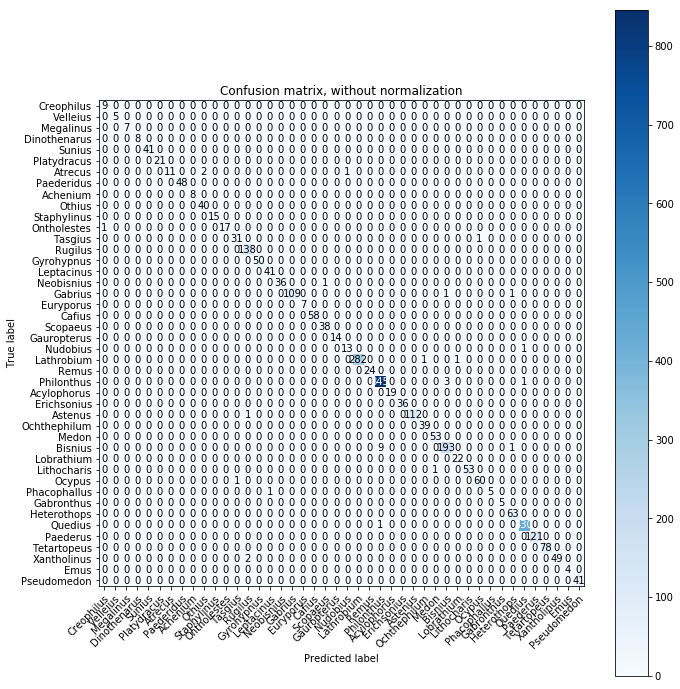

In [16]:
y_true = val_generator.classes
matplotlib.rcParams['figure.figsize'] = [10, 10]
plot_confusion_matrix(y_true, y_pred, np.array(labels))

In [17]:
labels = (val_generator.class_indices) # dict of label:index
labels = dict((i,l) for l,i in labels.items()) # dict of index:label

In [18]:
# create pd.dataframe and save predictions to .csv
#filenames=[datasetDir + name for name in val_generator.filenames]
#y_pred_labels = [labels[y] for y in y_pred]
#y_true_labels = [labels[y] for y in y_true]
#y_pred3_labels = []
#for i,top3 in enumerate(y_pred3):
#    l = []
#    for top in top3:
#        l.append((labels[top], Y_pred[i][top]))
#    y_pred3_labels.append(l)
#
#results=pd.DataFrame({"Filename":filenames,
#                      "Label":y_true_labels,
#                      "Prediction1":y_pred_labels,
#                      "Prediction3":y_pred3_labels})
#results.to_csv(results_file,index=True)

# create pd.dataframe and save predictions to .csv
filenames=[datasetDir + name for name in val_generator.filenames]
y_pred_labels = [labels[y] for y in y_pred]
y_true_labels = [labels[y] for y in y_true]
y_pred3_labels_prob = []

for i,top3 in enumerate(y_pred3):
    l = []
    for top in top3:
        l.append(labels[top])
        l.append(Y_pred[i][top])
    y_pred3_labels_prob.append(l)
y_pred3_labels_prob = np.array(y_pred3_labels_prob)

results=pd.DataFrame({"Filename":filenames,
                      "Label":y_true_labels,
                      "Prediction1":y_pred_labels,
                      "Prediction3a":y_pred3_labels_prob[:,0],
                      "Prediction3a_prob":y_pred3_labels_prob[:,1],
                      "Prediction3b":y_pred3_labels_prob[:,2],
                      "Prediction3b_prob":y_pred3_labels_prob[:,3],
                      "Prediction3c":y_pred3_labels_prob[:,4],
                      "Prediction3c_prob":y_pred3_labels_prob[:,5],
                     })
results.to_csv(results_file,index=True)